### Libraries

In [1]:
import os
import glob
import nibabel as nb
import scipy.stats
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.mesh.array_operations import smooth_array
from brainspace.datasets import load_mask

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# libraries
import numpy as np
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from brainspace.mesh.mesh_creation import build_polydata
import copy
from brainstat.datasets import fetch_mask
import matplotlib.cm as cm
import scipy as sp
from matplotlib.colors import ListedColormap
import cmocean

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np; np.random.seed(2)
import random; random.seed(2)
import joypy
from sklearn.preprocessing import minmax_scale
from scipy.interpolate import interp1d

Matplotlib is building the font cache; this may take a moment.


### Variables

In [2]:
# Set dataset PNI as working directory
os.chdir('/data_/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0')

# Path to MICAPIPE surf = mask_5k !
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

# Load native mid surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

inf32_lh = read_surface(micapipe + '/surfaces/fsLR-32k.L.inflated.surf.gii', itype='gii')
inf32_rh = read_surface(micapipe + '/surfaces/fsLR-32k.R.inflated.surf.gii', itype='gii')

mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_5k = np.concatenate((mask_lh, mask_rh), axis=0)

# Load spheres fsLR5k
sphere_lh = read_surface(micapipe+'/surfaces/fsLR-5k.L.sphere.surf.gii', itype='gii')
sphere_rh = read_surface(micapipe+'/surfaces/fsLR-5k.R.sphere.surf.gii', itype='gii')

# load stuff
mask_32k = load_mask(join=True)
mask_surf32 = mask_32k != 0

# Labels and boolean mask
mask_surf = mask_5k != 0

# Inflated fsLR-5k surfaces
f5k_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.surf.gii', itype='gii')
f5k_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.surf.gii', itype='gii')

# Load fsaverage5
fs5_lh = read_surface(micapipe+'/surfaces/fsaverage5/surf/lh.pial', itype='fs')
fs5_rh = read_surface(micapipe+'/surfaces/fsaverage5/surf/rh.pial', itype='fs')
fs5_mask = fetch_mask("fsaverage5")

## Create a brain mask derived from the thickness

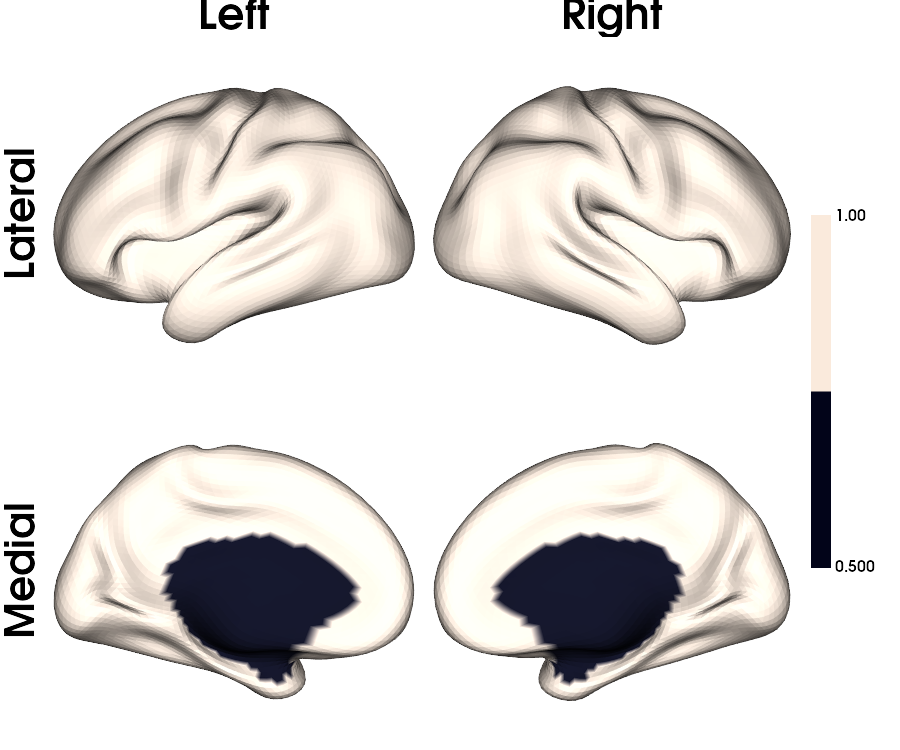

In [3]:
# Set dataset PNI as working directory
os.chdir('/data_/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0')

# Load thickness to make a better mask
lh_files = sorted(glob.glob('sub-PNC*/ses-01/maps/*_hemi-L_surf-fsLR-5k_label-thickness.func.gii'))
rh_files = sorted(glob.glob('sub-PNC*/ses-01/maps/*_hemi-R_surf-fsLR-5k_label-thickness.func.gii'))

# Load all the thickness data
Nth=np.concatenate((nb.load(lh_files[0]).darrays[0].data, nb.load(rh_files[0]).darrays[0].data), axis=0).shape[0]

surf_map=np.empty([len(lh_files), Nth], dtype=float)
for i, _ in enumerate(lh_files):
    surf_map[i,:] = np.hstack(np.concatenate((nb.load(lh_files[i]).darrays[0].data, nb.load(rh_files[i]).darrays[0].data), axis=0))
    # Mean matrix across the x axis (vertices)
    map_mean = np.mean(surf_map, axis=0)

#mask_5k = np.where(map_mean<0.3,False, True)
plot_hemispheres(inf_lh, inf_rh, array_name=mask_5k, cmap='rocket', nan_color=(0, 0, 0, 1),
                              zoom=1.3, size=(900, 750), embed_nb=True,
                              color_bar='right', layout_style='grid', color_range=(0.5,1),
                              label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']},
                              screenshot=False)

### Functions

In [4]:
def plot_histogram(data, bins=2000, title='Histogram', cmap='afmhot', Range=(0, 2500),
                   xlim=[0,2500], ylim=2000, mode_value=None, val2=None):
    non_zero_values = data[data != 0]
    n, bins, _ = plt.hist(non_zero_values, bins=bins, color='blue', alpha=0.7)
    bin_centers = (bins[:-1] + bins[1:]) / 2  # Compute the bin centers
    
    colormap = cm.get_cmap(cmap)
    colored_bins = colormap(np.interp(bin_centers, [Range[0], Range[1]], [0, 1]))
    plt.bar(bin_centers, n, width=np.diff(bin_centers[0:2]), color=colored_bins)
    
    plt.title(title)
    plt.xlabel('Intensity Value')
    plt.ylabel('Frequency')

    # Remove the outer box line
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    # Set the grid on the back
    plt.gca().set_axisbelow(True)
    plt.grid(color='gray', linestyle='dashed')

    # Plot a vertical line at the mode value
    if mode_value is not None:
        plt.axvline(x=mode_value[0], color='blue', linestyle='dashed', linewidth=2, label=f'Mode = {mode_value[0]}')
        plt.axvline(x=mode_value[1], color='green', linestyle='dashed', linewidth=2, label=f'Mode = {mode_value[1]}')
    if val2 is not None:
        plt.axvline(x=val2, color='white', linestyle='dashed', linewidth=2, label=f'ModeMRtrix = {val2}')
    
    plt.legend()
    
    # Set x-axis range (adjust as needed)
    plt.xlim(xlim)

    # Set y-axis range (adjust as needed)
    plt.ylim([0, ylim])
    
    plt.show()

# Smooth intencities
def smooth_surf(surf_l, surf_r, points, Mask, Kernel='uniform', Niter=3, Relax=0.35):
    '''
    This function smooth an array (left and right) on a given surface
    Parameters
    ----------
    surf_l : np.array left surface 
    surf_r : np.array right surface
    points : np.array surface data
    Kernel : {'uniform', 'gaussian', 'inverse_distance'}
    Niter  : int, optional Number of smooth iterations
    Relax  : relax : float, optional relaxation factor
    Mask   : str or 1D ndarray, optional
    Returns
    -------
    sdata : smoothed numpy array
    
    '''
    Ndim = Mask.shape[0] 
    n2dim = int(Ndim/2)
    Mask_l=Mask[0:n2dim]
    Mask_r=Mask[n2dim:Ndim]
    sdata = np.concatenate((smooth_array(surf_l, points[0:n2dim],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_l), 
                          smooth_array(surf_r, points[n2dim:Ndim],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_r)), axis=0)
    return(sdata)

# Smooth each intencity
def smooth_intensities(int_profile):
    smoothed_i = np.copy(int_profile)
   
    # smooth each intensity
    for i in range(int_profile.shape[0]):
        smoothed_i[i,:] = smooth_surf(inf_lh, inf_rh, int_profile[i,:], mask_surf,Niter=5, Relax=0.5, Kernel='uniform')
   
    return(smoothed_i)

def load_qmri_intensity(qmri=''):

    # Load CSV file containing subject and session information
    csv_dir = '/data/mica1/03_projects/youngeun/lists'
    csv_file = f"10PNC_{qmri}.csv"
    subject_session_info = pd.read_csv(csv_dir + '/' + csv_file, header=None, names=['info'], delimiter=',')

    # Extract subject and session information from each row
    files = []
    for index, row in subject_session_info.iterrows():
        info = row['info'].split(',')
        subject = index[4:]  # Extract subject ID
        session = info[0][4:].strip()  # Extract session ID
        file_path = f"sub-{subject}/ses-{session}/mpc-swm/acq-{qmri}/*_surf-fsLR-5k_desc-intensity_profiles.shape.gii"
        files.extend(glob.glob(file_path))
    
    # Print the file paths
    print("Files used:")
    for file_path in files:
        print(file_path)
    
    # Load intensity profiles from each file
    profiles = []
    for file_path in files:
        profile_data = nb.load(file_path).darrays[0].data
        profiles.append(profile_data)
    
    profiles = np.array(profiles)

    # Extract subject and session information
    subjects = set()
    for file_path in files:
        parts = file_path.split('/')
        subject = parts[0][4:]  # Extract subject ID from the directory name
        subjects.add(subject)

    print(f"Intensity Profiles of {qmri} maps - Number of subjects: {len(subjects)}")

    return profiles

In [5]:
def process_qmri_profiles():
    # List of qmri values
    qmri_values = ['T1map', 'MTSAT_protocol', 'T2star', 'FA', 'FOD', 'ODI']
    
    # Initialize variables to store each matrix
    T1map = None
    MTSAT = None
    T2star = None
    FA = None
    fod_tournier_afd = None

    # Load data and store matrices for each qmri value
    for qmri in qmri_values:
        # Load intensity profiles for the given qmri value
        profiles = load_qmri_intensity(qmri)
        # Store the matrix
        if qmri == 'T1map':
            T1map = profiles
        elif qmri == 'MTSAT_protocol':
            MTSAT = profiles
        elif qmri == 'T2star':
            T2star = profiles
        elif qmri == 'FA':
            FA = profiles
        elif qmri == 'FOD':
            fod_tournier_afd = profiles
        elif qmri == 'ODI':
            ODI = profiles

    return T1map, MTSAT, T2star, FA, fod_tournier_afd, ODI

# Call the function to load profiles for each qmri value and store them as matrices
T1map, MTSAT, T2star, FA, FOD, ODI = process_qmri_profiles()

Files used:
sub-PNC003/ses-03/mpc-swm/acq-T1map/sub-PNC003_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC006/ses-03/mpc-swm/acq-T1map/sub-PNC006_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC007/ses-03/mpc-swm/acq-T1map/sub-PNC007_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC009/ses-03/mpc-swm/acq-T1map/sub-PNC009_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC010/ses-03/mpc-swm/acq-T1map/sub-PNC010_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC015/ses-03/mpc-swm/acq-T1map/sub-PNC015_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC016/ses-03/mpc-swm/acq-T1map/sub-PNC016_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC018/ses-03/mpc-swm/acq-T1map/sub-PNC018_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC019/ses-03/mpc-swm/acq-T1map/sub-PNC019_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC022/ses-03/mpc-swm/acq-T1map/sub-PNC022_ses-03_surf-fsLR-5k_desc-intensi

In [6]:
## Average Intensity Profies
# Calculate mean matrix for each dataset
mean_T1map = np.mean(T1map, axis=0)
mean_MTSAT = np.mean(MTSAT, axis=0)
mean_T2star = np.mean(T2star, axis=0)
mean_FA = np.mean(FA, axis=0)
mean_FOD = np.mean(FOD, axis=0)
mean_ODI = np.mean(ODI, axis=0)

# Check the shape of mean matrices
print(f"Mean T1map matrix shape: {mean_T1map.shape}")
print(f"Mean MTSAT matrix shape: {mean_MTSAT.shape}")
print(f"Mean T2star matrix shape: {mean_T2star.shape}")
print(f"Mean FA matrix shape: {mean_FA.shape}")
print(f"Mean FOD matrix shape: {mean_FOD.shape}")
print(f"Mean ODI matrix shape: {mean_ODI.shape}")

Mean T1map matrix shape: (16, 9684)
Mean MTSAT matrix shape: (16, 9684)
Mean T2star matrix shape: (16, 9684)
Mean FA matrix shape: (16, 9684)
Mean FOD matrix shape: (16, 9684)
Mean ODI matrix shape: (16, 9684)


## Plot intensities

In [7]:
# plot ridge plot
def plot_ridgeplot(matrix, matrix_df=None, Cmap='rocket', Range=(2.5, 4.5), Xlab="flair", save_path=None, title=None):
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib as mpl

    #mean_row_values = np.mean(matrix, axis=1)
    #sorted_indices = np.argsort(mean_row_values)
    #sorted_matrix = matrix[sorted_indices]
    #sorted_id_x = np.array(matrix_df)[sorted_indices]

    ai = matrix.flatten()
    subject = np.array([])
    id_x = np.array([])

    for i in range(matrix.shape[0]):
        label = np.array([str(i+1) for j in range(matrix.shape[1])])
        subject = np.concatenate((subject, label))
        id_label = np.array([matrix_df[i] for j in range(matrix.shape[1])])
        id_x = np.concatenate((id_x, id_label))

    d = {'feature': ai,
         'subject': subject,
         'id_x': id_x
        }
    df = pd.DataFrame(d)

    f, axs = plt.subplots(nrows=matrix.shape[0], figsize=(3.468504*2.5, 2.220472*3.5), sharex=True, sharey=True)
    f.set_facecolor('none')

    x = np.linspace(Range[0], Range[1], 100)

    for i, ax in enumerate(axs, 1):
        sns.kdeplot(df[df["subject"]==str(i)]['feature'],
                    fill=True,
                    color="w",
                    alpha=0.25,
                    linewidth=1.5,
                    legend=False,
                    ax=ax)
        
        ax.set_xlim(Range[0], Range[1])
        
        im = ax.imshow(np.vstack([x, x]),
                       cmap=Cmap,
                       aspect="auto",
                       extent=[*ax.get_xlim(), *ax.get_ylim()]
                      )
        ax.collections
        path = ax.collections[0].get_paths()[0]
        patch = mpl.patches.PathPatch(path, transform=ax.transData)
        im.set_clip_path(patch)
           
        ax.spines[['left','right','bottom','top']].set_visible(False)
        
        if i != matrix.shape[0]:
            ax.tick_params(axis="x", length=0)
        else:
            ax.set_xlabel(Xlab)
            
        ax.set_yticks([])
        ax.set_ylabel("")
        
        ax.axhline(0, color="black")

        ax.set_facecolor("none")

    for i, ax in enumerate(axs):
        if i == matrix.shape[0] - 1:
            ax.set_xticks([Range[0], Range[1]])  # Set x-axis ticks for the bottom plot
        else:
            ax.set_xticks([])  # Remove x-axis ticks from other plots
        ax.text(0.05, 0.01, matrix_df[i], transform=ax.transAxes, fontsize=10, color='black', ha='left', va='bottom')

    plt.subplots_adjust(hspace=-0.8)
    
    if title:
        plt.suptitle(title, y=0.99, fontsize=16)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    else:
        plt.show()

In [8]:
def plot_ridgeplot(matrix, matrix_df=None, Cmap='rocket', Range=(2.5, 4.5), Xlab="flair", save_path=None, title=None, single_color=None, 
                   lcol="w", single_color_alpha=0.5):
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib as mpl

    # Ensure alpha is within the valid range
    if single_color_alpha < 0 or single_color_alpha > 1:
        raise ValueError("single_color_alpha must be between 0 and 1")

    # Prepare the data
    ai = matrix.flatten()
    subject = np.array([])
    id_x = np.array([])

    for i in range(matrix.shape[0]):
        label = np.array([str(i+1) for j in range(matrix.shape[1])])
        subject = np.concatenate((subject, label))
        id_label = np.array([matrix_df[i] for j in range(matrix.shape[1])])
        id_x = np.concatenate((id_x, id_label))

    d = {'feature': ai,
         'subject': subject,
         'id_x': id_x
        }
    df = pd.DataFrame(d)

    # Set up the plot
    f, axs = plt.subplots(nrows=matrix.shape[0], figsize=(3.468504*2.5, 2.220472*3.5), sharex=True, sharey=True)
    f.set_facecolor('none')

    x = np.linspace(Range[0], Range[1], 100)

    for i, ax in enumerate(axs, 1):
        sns.kdeplot(df[df["subject"]==str(i)]['feature'],
                    fill=True,
                    color=lcol,
                    alpha=0.25,
                    linewidth=1.5,
                    legend=False,
                    ax=ax)
        
        ax.set_xlim(Range[0], Range[1])
        
        if single_color:
            color = single_color
        else:
            color = Cmap
        
        if single_color:
            # Apply single color with specified alpha
            im = ax.imshow(np.vstack([x, x]),
                           cmap=None,
                           aspect="auto",
                           extent=[*ax.get_xlim(), *ax.get_ylim()],
                           vmin=0, vmax=1)  # Use dummy values for vmin and vmax
            im.set_cmap(None)
            # Create RGBA color with specified alpha
            rgba_color = mpl.colors.to_rgba(single_color, alpha=single_color_alpha)
            im.set_array(np.array([[0.5]] * len(x)))  # Use a constant array for coloring
            im.set_cmap(mpl.colors.ListedColormap([rgba_color]))
        else:
            # Use the colormap
            im = ax.imshow(np.vstack([x, x]),
                           cmap=Cmap,
                           aspect="auto",
                           extent=[*ax.get_xlim(), *ax.get_ylim()]
                          )
        
        ax.collections
        path = ax.collections[0].get_paths()[0]
        patch = mpl.patches.PathPatch(path, transform=ax.transData)
        im.set_clip_path(patch)
           
        ax.spines[['left','right','bottom','top']].set_visible(False)
        
        if i != matrix.shape[0]:
            ax.tick_params(axis="x", length=0)
        else:
            ax.set_xlabel(Xlab)
            
        ax.set_yticks([])
        ax.set_ylabel("")
        
        ax.axhline(0, color="black")

        ax.set_facecolor("none")

    for i, ax in enumerate(axs):
        if i == matrix.shape[0] - 1:
            ax.set_xticks([Range[0], Range[1]])  # Set x-axis ticks for the bottom plot
        else:
            ax.set_xticks([])  # Remove x-axis ticks from other plots
        ax.text(0.05, 0.01, matrix_df[i], transform=ax.transAxes, fontsize=10, color='black', ha='left', va='bottom')

    plt.subplots_adjust(hspace=-0.8)
    
    if title:
        plt.suptitle(title, y=0.99, fontsize=16)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    else:
        plt.show()


In [9]:
def plot_ridgeplot(matrix, matrix_df=None, Cmap='rocket', Range=(2.5, 4.5), Xlab="flair", save_path=None, title=None, single_color=None, single_color_alpha=0.5):
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib as mpl

    # Ensure alpha is within the valid range
    if single_color_alpha < 0 or single_color_alpha > 1:
        raise ValueError("single_color_alpha must be between 0 and 1")

    # Prepare the data
    ai = matrix.flatten()
    subject = np.array([])
    id_x = np.array([])

    for i in range(matrix.shape[0]):
        label = np.array([str(i+1) for j in range(matrix.shape[1])])
        subject = np.concatenate((subject, label))
        id_label = np.array([matrix_df[i] for j in range(matrix.shape[1])])
        id_x = np.concatenate((id_x, id_label))

    d = {'feature': ai,
         'subject': subject,
         'id_x': id_x
        }
    df = pd.DataFrame(d)

    # Set up the plot
    f, axs = plt.subplots(nrows=matrix.shape[0], figsize=(3.468504*2.5, 2.220472*3.5), sharex=True, sharey=True)
    f.set_facecolor('none')

    x = np.linspace(Range[0], Range[1], 100)

    for i, ax in enumerate(axs, 1):
        sns.kdeplot(df[df["subject"]==str(i)]['feature'],
                    fill=True,
                    color="w",  # Set edge color to gray
                    alpha=0.25,
                    linewidth=1.5,
                    legend=False,  # Ensure legend is not included
                    ax=ax)
        
        ax.set_xlim(Range[0], Range[1])
        
        if single_color:
            color = single_color
        else:
            color = Cmap
        
        if single_color:
            # Apply single color with specified alpha
            im = ax.imshow(np.vstack([x, x]),
                           cmap=None,
                           aspect="auto",
                           extent=[*ax.get_xlim(), *ax.get_ylim()],
                           vmin=0, vmax=1)  # Use dummy values for vmin and vmax
            im.set_cmap(None)
            # Create RGBA color with specified alpha
            rgba_color = mpl.colors.to_rgba(single_color, alpha=single_color_alpha)
            im.set_array(np.array([[0.5]] * len(x)))  # Use a constant array for coloring
            im.set_cmap(mpl.colors.ListedColormap([rgba_color]))
        else:
            # Use the colormap
            im = ax.imshow(np.vstack([x, x]),
                           cmap=Cmap,
                           aspect="auto",
                           extent=[*ax.get_xlim(), *ax.get_ylim()]
                          )
        
        ax.collections
        path = ax.collections[0].get_paths()[0]
        patch = mpl.patches.PathPatch(path, transform=ax.transData)
        im.set_clip_path(patch)
           
        ax.spines[['left','right','bottom','top']].set_visible(False)
        
        if i != matrix.shape[0]:
            ax.tick_params(axis="x", length=0)
        else:
            ax.set_xlabel(Xlab)
            
        ax.set_yticks([])
        ax.set_ylabel("")
        
        ax.axhline(0, color="black")

        ax.set_facecolor("none")
        
        # Remove x-axis ticks and labels
        ax.set_xticks([])  # Remove x-axis ticks
        ax.set_xticklabels([])  # Remove x-axis tick labels

    # Removed the ax.text line to eliminate labels on the plot
    # ax.text(0.05, 0.01, matrix_df[i], transform=ax.transAxes, fontsize=10, color='black', ha='left', va='bottom')

    plt.subplots_adjust(hspace=-0.8)
    
    if title:
        plt.suptitle(title, y=0.99, fontsize=16)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    else:
        plt.show()


## Mesulam Claases

In [10]:
mesuL_5k =  nb.load(micapipe + '/surfaces/fsLR-5k.L_mesulam.shape.gii').darrays[0].data
mesuR_5k =  nb.load(micapipe + '/surfaces/fsLR-5k.R_mesulam.shape.gii').darrays[0].data
mesu_5k = np.concatenate((mesuL_5k, mesuR_5k), axis=0)
mesu_5k_round = np.round(mesu_5k)

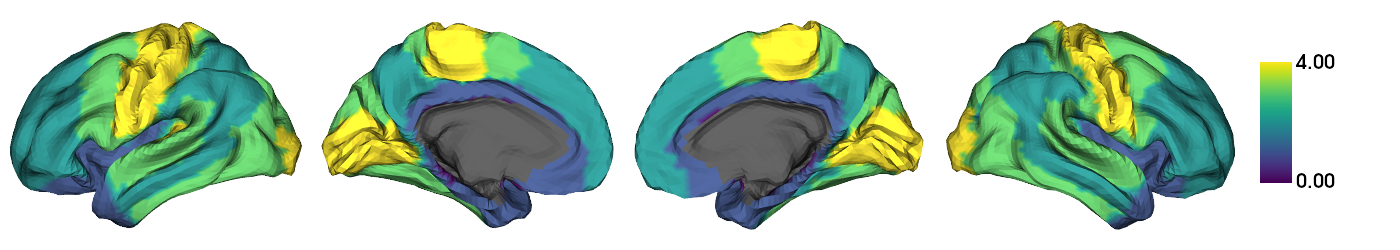

In [11]:
mesu_5k_round[mask_5k == False] = np.nan

# plot labels on surface
plot_hemispheres(f5k_lh, f5k_rh, mesu_5k_round, cmap='viridis', nan_color=(0.3, 0.3, 0.3, 1),
                      zoom=1.5, size=(1400, 250), embed_nb=True,
                      color_bar='right', cb__labelTextProperty={"fontSize": 20})

In [12]:
filtered_maps = {}

for value in range(5):
    filtered_map = np.where(mesu_5k_round == value, mean_T1map, np.nan)
    filtered_maps[value] = filtered_map

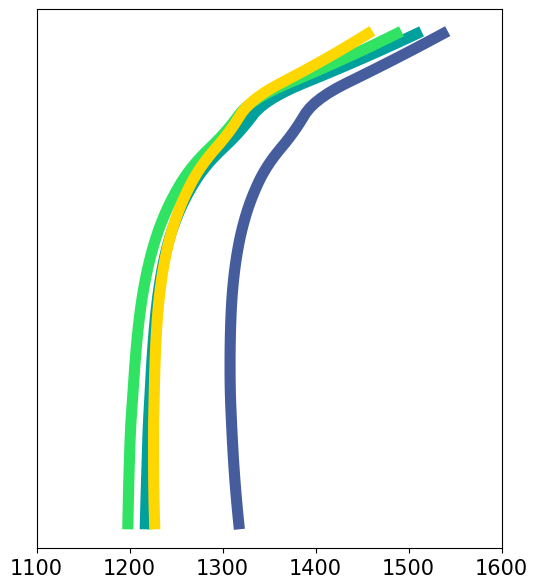

In [13]:
filtered_maps = {}
for value in range(5):
    filtered_map = np.where(mesu_5k_round == value, mean_T1map, np.nan)
    filtered_maps[value] = filtered_map

mean_values_dict = {}
for key in range(1, 5):
    mean_values_dict[key] = np.nanmean(filtered_maps[key], axis=1)

# Plot
plt.figure(figsize=(6, 7))

# Smoothed profiles
smoothed_profiles = []
x_values = np.arange(mean_values_dict[1].shape[0])

for key in mean_values_dict:
    f = interp1d(x_values, mean_values_dict[key], kind='quadratic')
    x_interp = np.linspace(0, len(mean_values_dict[key]) - 1, 100)
    y_interp = f(x_interp)
    smoothed_profiles.append(y_interp)

# User-defined colors and line styles
colors_profiles = ['#455d9cff', '#00a09dff', '#31e363ff', 'gold']

# Plotting profiles
for smoothed_profile, color in zip(smoothed_profiles, colors_profiles):
    plt.plot(smoothed_profile, x_interp, color=color, linewidth=8)

plt.xlim(1100, 1600)
plt.yticks([])
plt.xticks(fontsize=15)
plt.show()

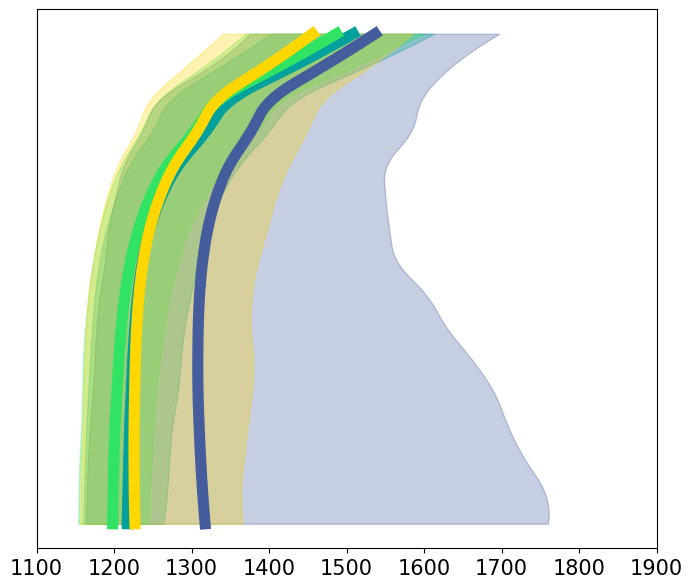

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Assuming mesu_5k_round and mean_T1map are defined and available

filtered_maps = {}
for value in range(5):
    filtered_map = np.where(mesu_5k_round == value, mean_T1map, np.nan)
    filtered_maps[value] = filtered_map

mean_values_dict = {}
percentile_5_values_dict = {}
percentile_95_values_dict = {}
for key in range(1, 5):
    mean_values_dict[key] = np.nanmean(filtered_maps[key], axis=1)
    percentile_5_values_dict[key] = np.nanpercentile(filtered_maps[key], 5, axis=1)
    percentile_95_values_dict[key] = np.nanpercentile(filtered_maps[key], 95, axis=1)

# Plot
plt.figure(figsize=(8, 7))

# Smoothed profiles
smoothed_profiles = []
smoothed_percentile_5_profiles = []
smoothed_percentile_95_profiles = []
x_values = np.arange(mean_values_dict[1].shape[0])

for key in mean_values_dict:
    f_mean = interp1d(x_values, mean_values_dict[key], kind='quadratic')
    f_percentile_5 = interp1d(x_values, percentile_5_values_dict[key], kind='quadratic')
    f_percentile_95 = interp1d(x_values, percentile_95_values_dict[key], kind='quadratic')
    x_interp = np.linspace(0, len(mean_values_dict[key]) - 1, 100)
    y_interp_mean = f_mean(x_interp)
    y_interp_percentile_5 = f_percentile_5(x_interp)
    y_interp_percentile_95 = f_percentile_95(x_interp)
    smoothed_profiles.append(y_interp_mean)
    smoothed_percentile_5_profiles.append(y_interp_percentile_5)
    smoothed_percentile_95_profiles.append(y_interp_percentile_95)

# User-defined colors and line styles
colors_profiles = ['#455d9cff', '#00a09dff', '#31e363ff', 'gold']

# Plotting profiles
for smoothed_profile, smoothed_percentile_5_profile, smoothed_percentile_95_profile, color in zip(smoothed_profiles, smoothed_percentile_5_profiles, smoothed_percentile_95_profiles, colors_profiles):
    plt.plot(smoothed_profile, x_interp, color=color, linewidth=8)
    plt.fill_betweenx(x_interp, smoothed_percentile_5_profile, smoothed_percentile_95_profile, color=color, alpha=0.3)

plt.xlim(1100, 1900)
plt.yticks([])
plt.xticks(fontsize=15)
plt.show()


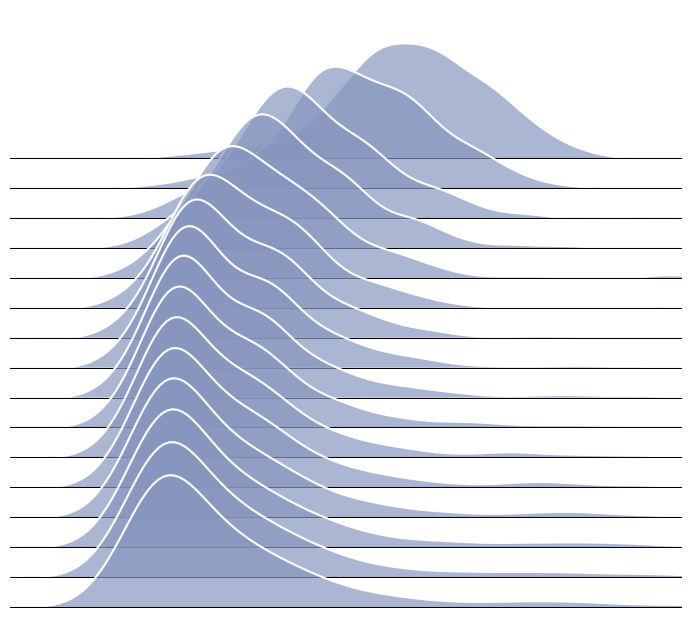

In [217]:
flip_img = np.flip(filtered_maps[1], axis=0)
plot_ridgeplot(matrix=flip_img, matrix_df=labels, Range=(1000, 1900), Xlab="", single_color='#455d9cff', single_color_alpha=0.6)

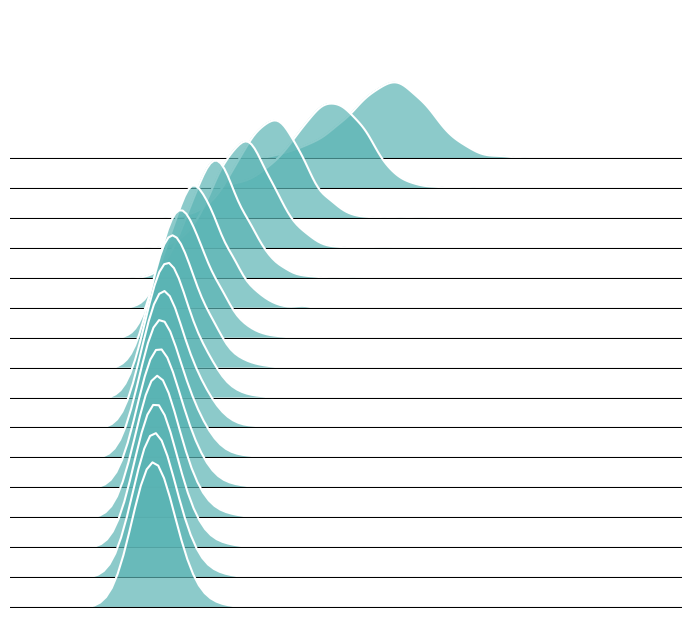

In [218]:
flip_img = np.flip(filtered_maps[2], axis=0)
plot_ridgeplot(matrix=flip_img, matrix_df=labels, Cmap='cmo.thermal', Range=(1000, 1900), Xlab="", single_color='darkcyan', single_color_alpha=0.6)

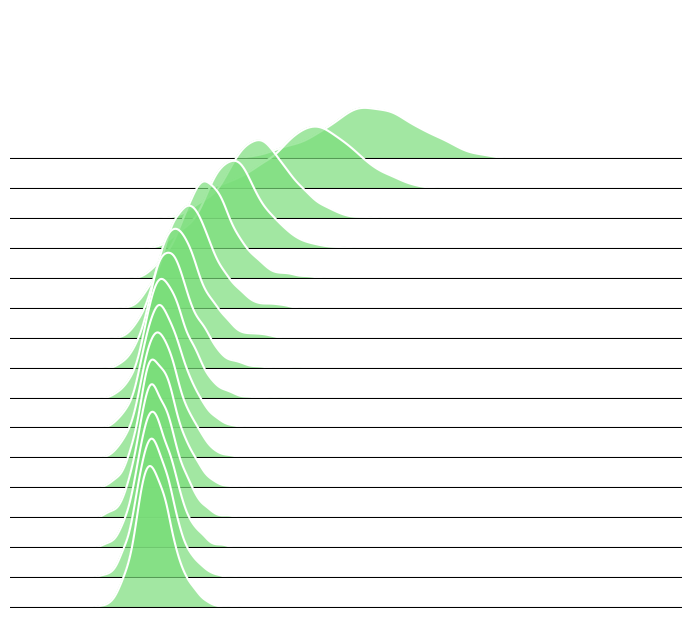

In [219]:
flip_img = np.flip(filtered_maps[3], axis=0)
plot_ridgeplot(matrix=flip_img, matrix_df=labels, Cmap='cmo.thermal', Range=(1000, 1900), Xlab="", single_color='limegreen', single_color_alpha=0.6)

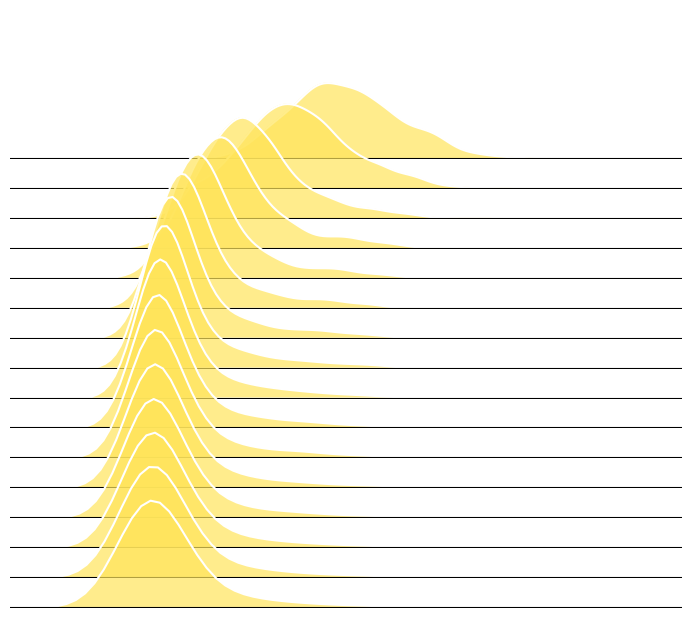

In [220]:
flip_img = np.flip(filtered_maps[4], axis=0)
plot_ridgeplot(matrix=flip_img, matrix_df=labels, Cmap='cmo.thermal', Range=(1000, 1900), Xlab="", single_color='gold', single_color_alpha=0.6)

In [25]:
filtered_maps = {}

for value in range(5):
    filtered_map = np.where(mesu_5k_round == value, mean_MTSAT, np.nan)
    filtered_maps[value] = filtered_map

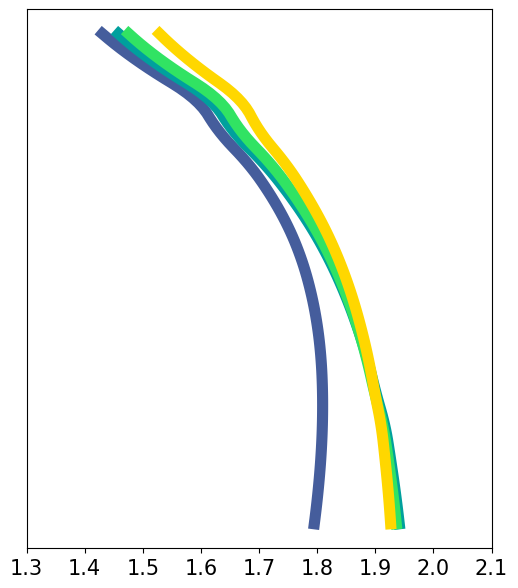

In [26]:
filtered_maps = {}
for value in range(5):
    filtered_map = np.where(mesu_5k_round == value, mean_MTSAT, np.nan)
    filtered_maps[value] = filtered_map

mean_values_dict = {}
for key in range(1, 5):
    mean_values_dict[key] = np.nanmean(filtered_maps[key], axis=1)

# Plot
plt.figure(figsize=(6, 7))

# Smoothed profiles
smoothed_profiles = []
x_values = np.arange(mean_values_dict[1].shape[0])

for key in mean_values_dict:
    f = interp1d(x_values, mean_values_dict[key], kind='quadratic')
    x_interp = np.linspace(0, len(mean_values_dict[key]) - 1, 100)
    y_interp = f(x_interp)
    smoothed_profiles.append(y_interp)

# User-defined colors and line styles
colors_profiles = ['#455d9cff', '#00a09dff', '#31e363ff', 'gold']

# Plotting profiles
for smoothed_profile, color in zip(smoothed_profiles, colors_profiles):
    plt.plot(smoothed_profile, x_interp, color=color, linewidth=8)

plt.xlim(1.3, 2.1)
plt.yticks([])
plt.xticks(fontsize=15)
plt.show()

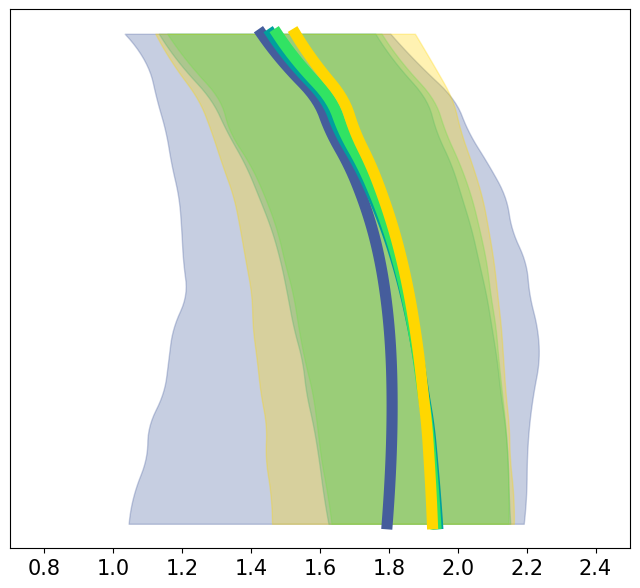

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Assuming mesu_5k_round and mean_MTSAT are defined and available

filtered_maps = {}
for value in range(5):
    filtered_map = np.where(mesu_5k_round == value, mean_MTSAT, np.nan)
    filtered_maps[value] = filtered_map

mean_values_dict = {}
percentile_5_values_dict = {}
percentile_95_values_dict = {}
for key in range(1, 5):
    mean_values_dict[key] = np.nanmean(filtered_maps[key], axis=1)
    percentile_5_values_dict[key] = np.nanpercentile(filtered_maps[key], 5, axis=1)
    percentile_95_values_dict[key] = np.nanpercentile(filtered_maps[key], 95, axis=1)

# Plot
plt.figure(figsize=(8, 7))

# Smoothed profiles
smoothed_profiles = []
smoothed_percentile_5_profiles = []
smoothed_percentile_95_profiles = []
x_values = np.arange(mean_values_dict[1].shape[0])

for key in mean_values_dict:
    f_mean = interp1d(x_values, mean_values_dict[key], kind='quadratic')
    f_percentile_5 = interp1d(x_values, percentile_5_values_dict[key], kind='quadratic')
    f_percentile_95 = interp1d(x_values, percentile_95_values_dict[key], kind='quadratic')
    x_interp = np.linspace(0, len(mean_values_dict[key]) - 1, 100)
    y_interp_mean = f_mean(x_interp)
    y_interp_percentile_5 = f_percentile_5(x_interp)
    y_interp_percentile_95 = f_percentile_95(x_interp)
    smoothed_profiles.append(y_interp_mean)
    smoothed_percentile_5_profiles.append(y_interp_percentile_5)
    smoothed_percentile_95_profiles.append(y_interp_percentile_95)

# User-defined colors and line styles
colors_profiles = ['#455d9cff', '#00a09dff', '#31e363ff', 'gold']

# Plotting profiles
for smoothed_profile, smoothed_percentile_5_profile, smoothed_percentile_95_profile, color in zip(smoothed_profiles, smoothed_percentile_5_profiles, smoothed_percentile_95_profiles, colors_profiles):
    plt.plot(smoothed_profile, x_interp, color=color, linewidth=8)
    plt.fill_betweenx(x_interp, smoothed_percentile_5_profile, smoothed_percentile_95_profile, color=color, alpha=0.3)

plt.xlim(0.7, 2.5)
plt.yticks([])
plt.xticks(fontsize=15)
plt.show()


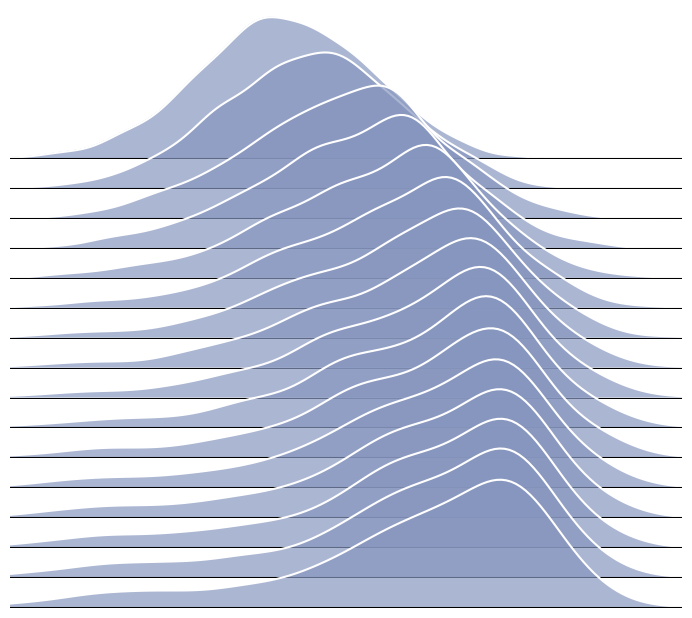

In [186]:
flip_img = np.flip(filtered_maps[1], axis=0)
plot_ridgeplot(matrix=flip_img, matrix_df=labels, Range=(0.7, 2.5), Xlab="", single_color='#455d9cff', single_color_alpha=0.6)

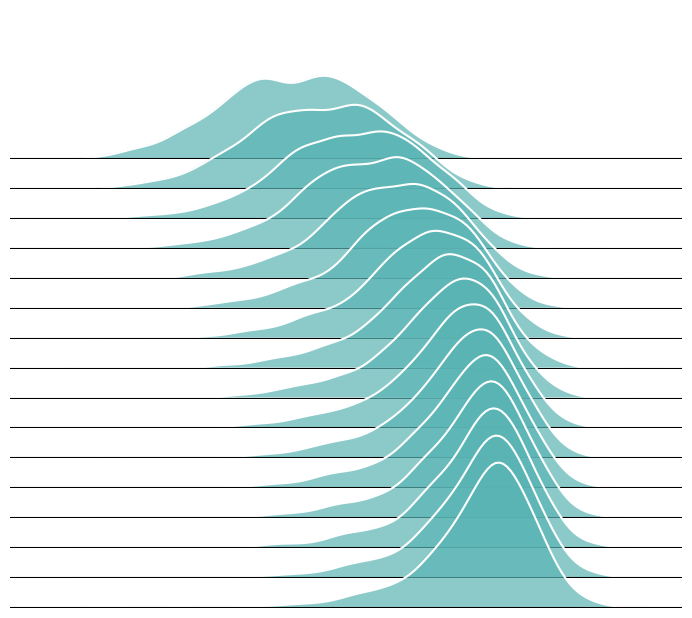

In [187]:
flip_img = np.flip(filtered_maps[2], axis=0)
plot_ridgeplot(matrix=flip_img, matrix_df=labels, Range=(0.7, 2.5), Xlab="", single_color='darkcyan', single_color_alpha=0.6)

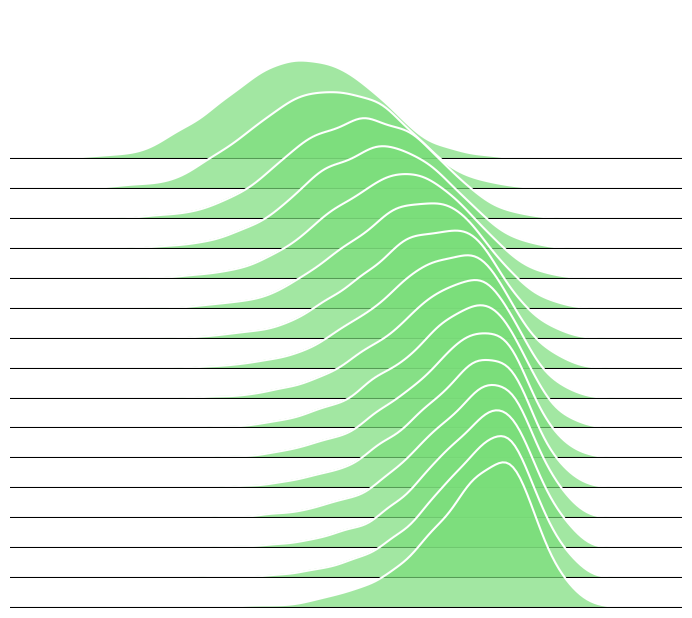

In [188]:
flip_img = np.flip(filtered_maps[3], axis=0)
plot_ridgeplot(matrix=flip_img, matrix_df=labels, Range=(0.7, 2.5), Xlab="", single_color='limegreen', single_color_alpha=0.6)

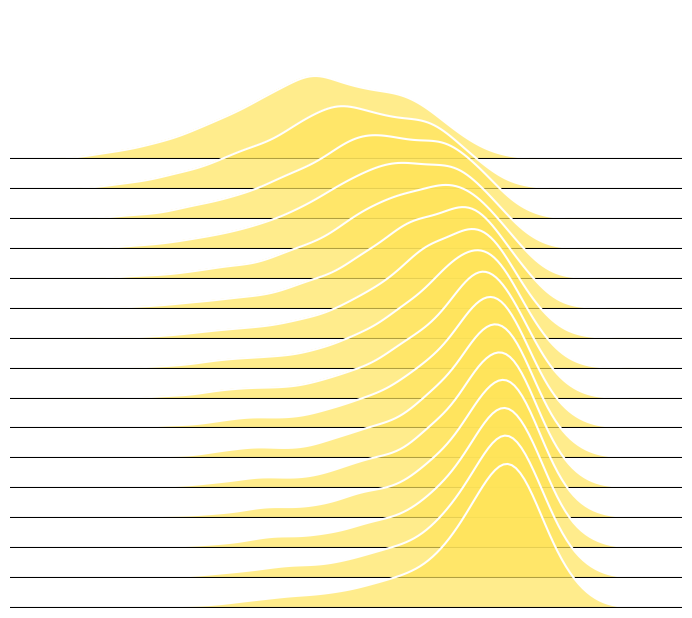

In [189]:
flip_img = np.flip(filtered_maps[4], axis=0)
plot_ridgeplot(matrix=flip_img, matrix_df=labels, Range=(0.7, 2.5), Xlab="", single_color='gold', single_color_alpha=0.6)

## Von Economo classes

In [27]:
ecoL_5k =  nb.load('/data/mica1/03_projects/youngeun/parc/economo_fsLR5k.L.shape.gii').darrays[0].data
ecoR_5k =  nb.load('/data/mica1/03_projects/youngeun/parc/economo_fsLR5k.R.shape.gii').darrays[0].data
eco_5k = np.concatenate((ecoL_5k, ecoR_5k), axis=0)
eco_5k_round = np.round(eco_5k)

/tmp/ipykernel_910356/1914294625.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', 7)


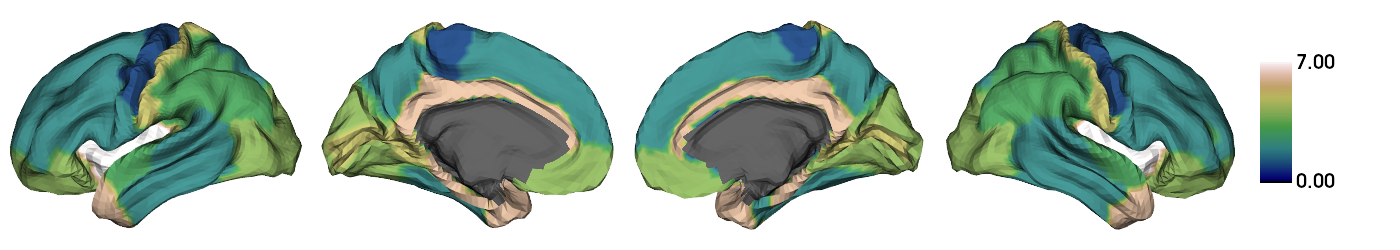

In [28]:
eco_5k_round[mask_5k == False] = np.nan
#Accent
cmap = cm.get_cmap('viridis', 7)
# plot labels on surface
plot_hemispheres(f5k_lh, f5k_rh, eco_5k_round, cmap='gist_earth', nan_color=(0.3, 0.3, 0.3, 1),
                      zoom=1.5, size=(1400, 250), embed_nb=True,
                      color_bar='right', cb__labelTextProperty={"fontSize": 20})

In [29]:
filtered_maps = {}

for value in range(8):
    filtered_map = np.where(eco_5k_round == value, mean_T1map, np.nan)
    filtered_maps[value] = filtered_map

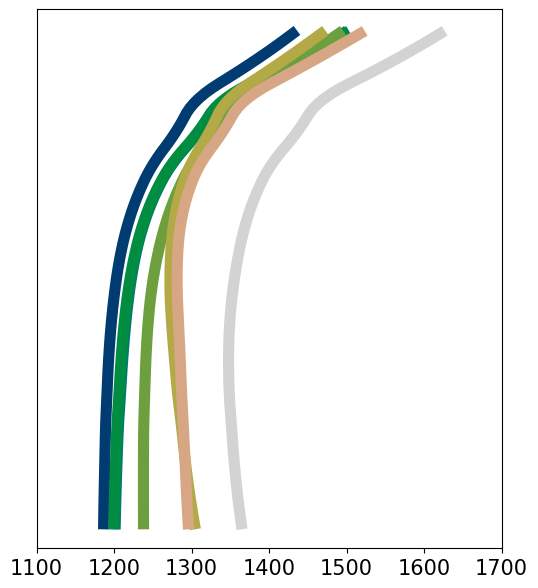

In [30]:
filtered_maps = {}
for value in range(8):
    filtered_map = np.where(eco_5k_round == value, mean_T1map, np.nan)
    filtered_maps[value] = filtered_map

mean_values_dict = {}
for key in range(1, 8):
    mean_values_dict[key] = np.nanmean(filtered_maps[key], axis=1)

# Plot
plt.figure(figsize=(6, 7))

# Smoothed profiles
smoothed_profiles = []
x_values = np.arange(mean_values_dict[1].shape[0])

for key in mean_values_dict:
    f = interp1d(x_values, mean_values_dict[key], kind='quadratic')
    x_interp = np.linspace(0, len(mean_values_dict[key]) - 1, 100)
    y_interp = f(x_interp)
    smoothed_profiles.append(y_interp)

# User-defined colors and line styles
colors_profiles = ['#003b72ff', '#007874ff', '#008d41ff', '#6d9f3eff', '#b3aa47ff', '#d7a785ff', 'lightgray']

# Plotting profiles
for smoothed_profile, color in zip(smoothed_profiles, colors_profiles):
    plt.plot(smoothed_profile, x_interp, color=color, linewidth=8)

plt.xlim(1100, 1700)
plt.yticks([])
plt.xticks(fontsize=15)
plt.show()

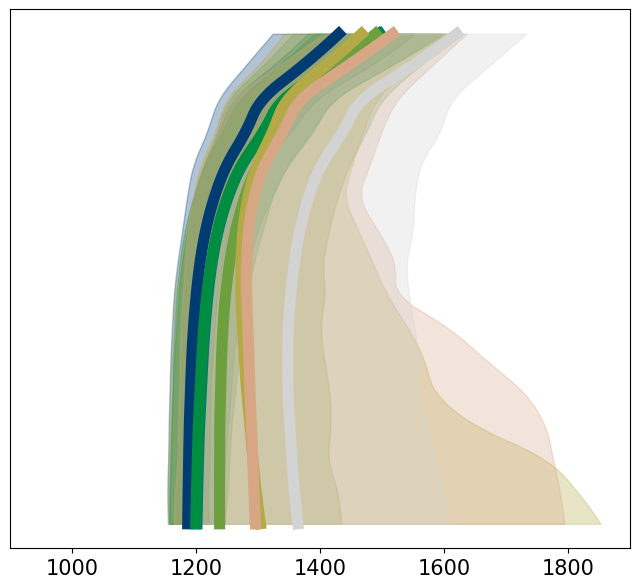

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Assuming eco_5k_round and mean_T1map are defined and available

filtered_maps = {}
for value in range(8):
    filtered_map = np.where(eco_5k_round == value, mean_T1map, np.nan)
    filtered_maps[value] = filtered_map

mean_values_dict = {}
percentile_5_values_dict = {}
percentile_95_values_dict = {}
for key in range(1, 8):
    mean_values_dict[key] = np.nanmean(filtered_maps[key], axis=1)
    percentile_5_values_dict[key] = np.nanpercentile(filtered_maps[key], 5, axis=1)
    percentile_95_values_dict[key] = np.nanpercentile(filtered_maps[key], 95, axis=1)

# Plot
plt.figure(figsize=(8, 7))

# Smoothed profiles
smoothed_profiles = []
smoothed_percentile_5_profiles = []
smoothed_percentile_95_profiles = []
x_values = np.arange(mean_values_dict[1].shape[0])

for key in mean_values_dict:
    f_mean = interp1d(x_values, mean_values_dict[key], kind='quadratic')
    f_percentile_5 = interp1d(x_values, percentile_5_values_dict[key], kind='quadratic')
    f_percentile_95 = interp1d(x_values, percentile_95_values_dict[key], kind='quadratic')
    x_interp = np.linspace(0, len(mean_values_dict[key]) - 1, 100)
    y_interp_mean = f_mean(x_interp)
    y_interp_percentile_5 = f_percentile_5(x_interp)
    y_interp_percentile_95 = f_percentile_95(x_interp)
    smoothed_profiles.append(y_interp_mean)
    smoothed_percentile_5_profiles.append(y_interp_percentile_5)
    smoothed_percentile_95_profiles.append(y_interp_percentile_95)

# User-defined colors and line styles
colors_profiles = ['#003b72ff', '#007874ff', '#008d41ff', '#6d9f3eff', '#b3aa47ff', '#d7a785ff', 'lightgray']

# Plotting profiles
for smoothed_profile, smoothed_percentile_5_profile, smoothed_percentile_95_profile, color in zip(smoothed_profiles, smoothed_percentile_5_profiles, smoothed_percentile_95_profiles, colors_profiles):
    plt.plot(smoothed_profile, x_interp, color=color, linewidth=8)
    plt.fill_betweenx(x_interp, smoothed_percentile_5_profile, smoothed_percentile_95_profile, color=color, alpha=0.3)

plt.xlim(900, 1900)
plt.yticks([])
plt.xticks(fontsize=15)
plt.show()


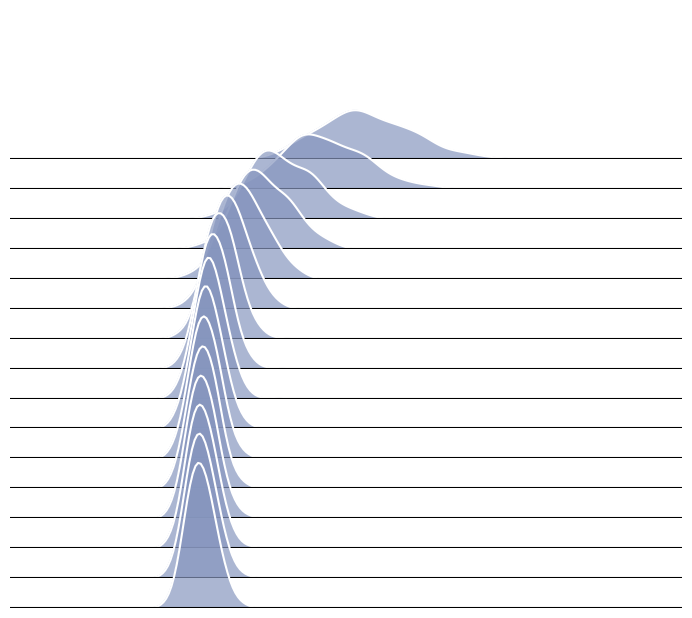

In [284]:
flip_img = np.flip(filtered_maps[1], axis=0)
plot_ridgeplot(matrix=flip_img, matrix_df=labels, Range=(900, 1900), Xlab="", single_color='#455d9cff', single_color_alpha=0.6)

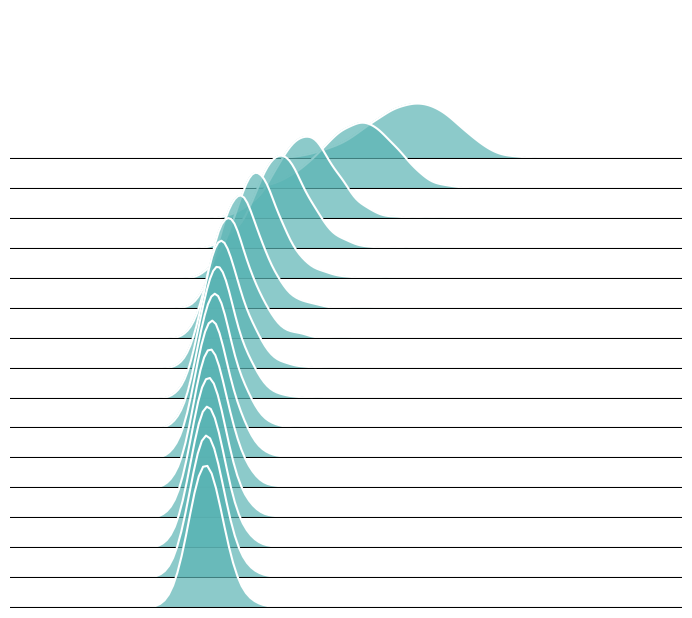

In [285]:
flip_img = np.flip(filtered_maps[2], axis=0)
plot_ridgeplot(matrix=flip_img, matrix_df=labels, Range=(900, 1900), Xlab="", single_color='darkcyan', single_color_alpha=0.6)

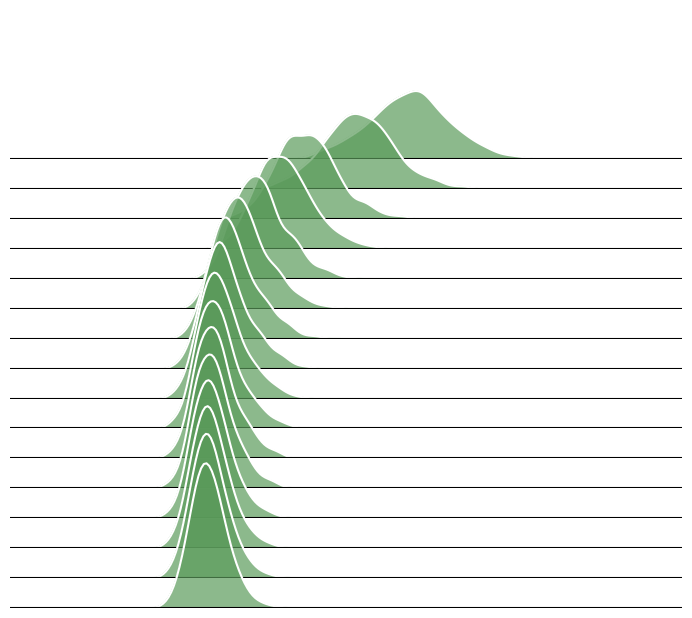

In [287]:
flip_img = np.flip(filtered_maps[3], axis=0)
plot_ridgeplot(matrix=flip_img, matrix_df=labels, Range=(900, 1900), Xlab="", single_color='darkgreen', single_color_alpha=0.6)

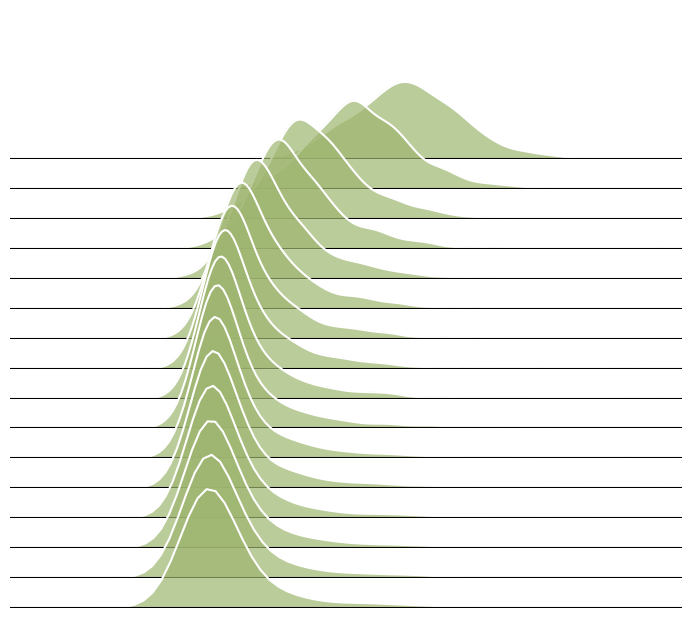

In [288]:
flip_img = np.flip(filtered_maps[4], axis=0)
plot_ridgeplot(matrix=flip_img, matrix_df=labels, Range=(900, 1900), Xlab="", single_color='olivedrab', single_color_alpha=0.6)

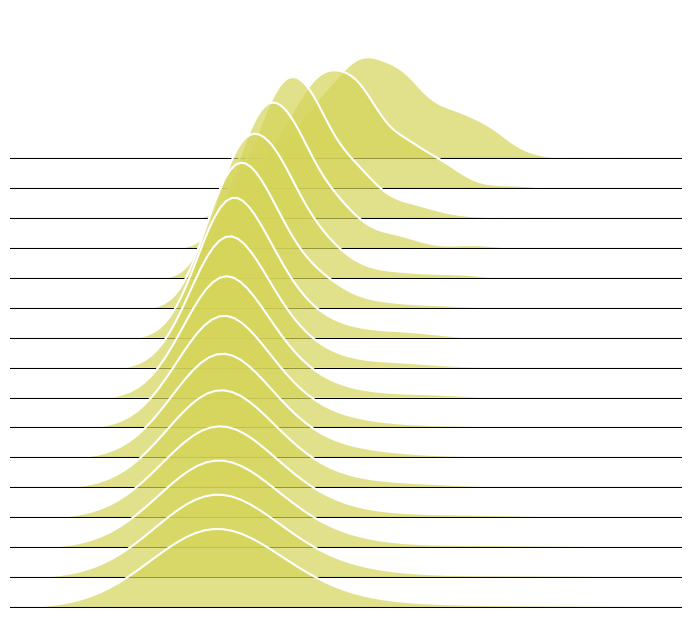

In [281]:
flip_img = np.flip(filtered_maps[5], axis=0)
plot_ridgeplot(matrix=flip_img, matrix_df=labels, Range=(900, 1900), Xlab="", single_color='y', single_color_alpha=0.6)

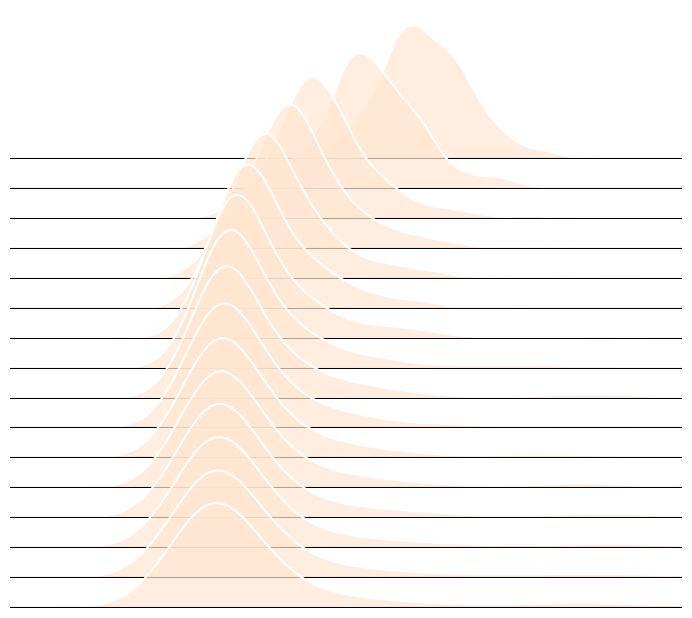

In [282]:
flip_img = np.flip(filtered_maps[6], axis=0)
plot_ridgeplot(matrix=flip_img, matrix_df=labels, Range=(900, 1900), Xlab="", single_color='peachpuff', single_color_alpha=0.6)

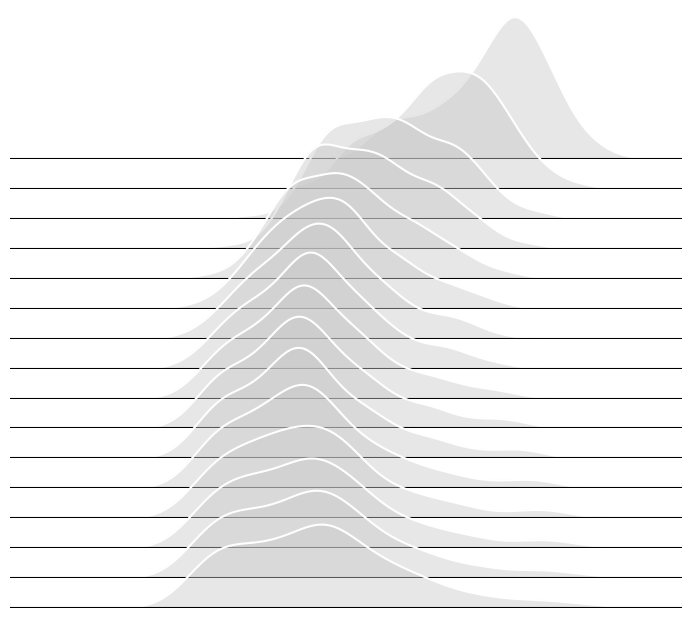

In [283]:
flip_img = np.flip(filtered_maps[7], axis=0)
plot_ridgeplot(matrix=flip_img, matrix_df=labels, Range=(900, 1900), Xlab="", single_color='gray', single_color_alpha=0.25)

In [32]:
filtered_maps = {}

for value in range(8):
    filtered_map = np.where(eco_5k_round == value, mean_MTSAT, np.nan)
    filtered_maps[value] = filtered_map

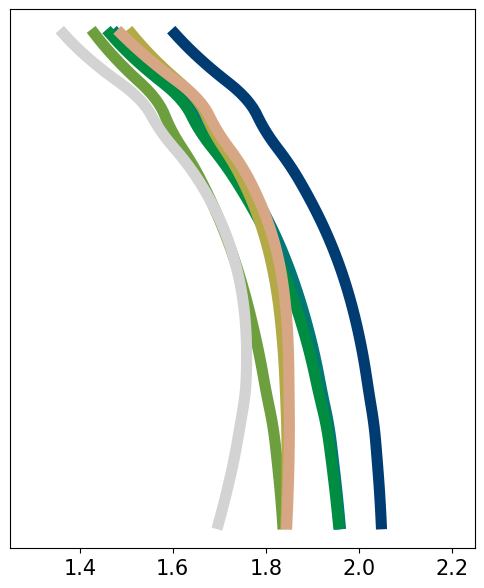

In [33]:
filtered_maps = {}
for value in range(8):
    filtered_map = np.where(eco_5k_round == value, mean_MTSAT, np.nan)
    filtered_maps[value] = filtered_map

mean_values_dict = {}
for key in range(1, 8):
    mean_values_dict[key] = np.nanmean(filtered_maps[key], axis=1)

# Plot
plt.figure(figsize=(6, 7))

# Smoothed profiles
smoothed_profiles = []
x_values = np.arange(mean_values_dict[1].shape[0])

for key in mean_values_dict:
    f = interp1d(x_values, mean_values_dict[key], kind='quadratic')
    x_interp = np.linspace(0, len(mean_values_dict[key]) - 1, 100)
    y_interp = f(x_interp)
    smoothed_profiles.append(y_interp)

# User-defined colors and line styles
colors_profiles = ['#003b72ff', '#007874ff', '#008d41ff', '#6d9f3eff', '#b3aa47ff', '#d7a785ff', 'lightgray']

# Plotting profiles
for smoothed_profile, color in zip(smoothed_profiles, colors_profiles):
    plt.plot(smoothed_profile, x_interp, color=color, linewidth=8)

plt.xlim(1.25, 2.25)
plt.yticks([])
plt.xticks(fontsize=15)
plt.show()

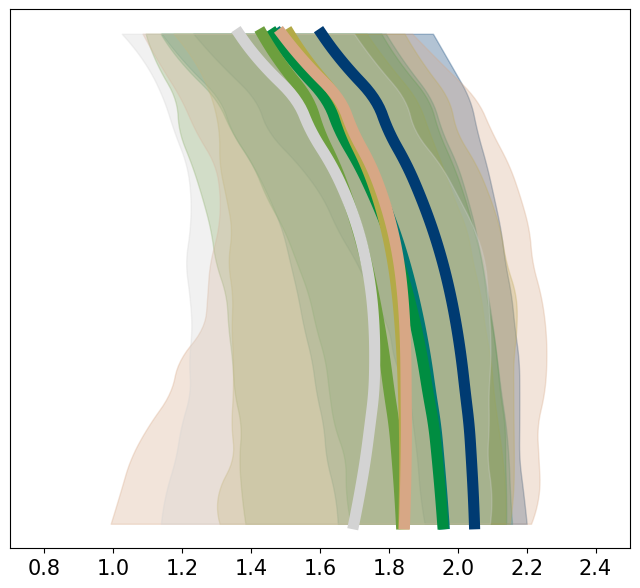

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Assuming eco_5k_round and mean_MTSAT are defined and available

filtered_maps = {}
for value in range(8):
    filtered_map = np.where(eco_5k_round == value, mean_MTSAT, np.nan)
    filtered_maps[value] = filtered_map

mean_values_dict = {}
percentile_5_values_dict = {}
percentile_95_values_dict = {}
for key in range(1, 8):
    mean_values_dict[key] = np.nanmean(filtered_maps[key], axis=1)
    percentile_5_values_dict[key] = np.nanpercentile(filtered_maps[key], 5, axis=1)
    percentile_95_values_dict[key] = np.nanpercentile(filtered_maps[key], 95, axis=1)

# Plot
plt.figure(figsize=(8, 7))

# Smoothed profiles
smoothed_profiles = []
smoothed_percentile_5_profiles = []
smoothed_percentile_95_profiles = []
x_values = np.arange(mean_values_dict[1].shape[0])

for key in mean_values_dict:
    f_mean = interp1d(x_values, mean_values_dict[key], kind='quadratic')
    f_percentile_5 = interp1d(x_values, percentile_5_values_dict[key], kind='quadratic')
    f_percentile_95 = interp1d(x_values, percentile_95_values_dict[key], kind='quadratic')
    x_interp = np.linspace(0, len(mean_values_dict[key]) - 1, 100)
    y_interp_mean = f_mean(x_interp)
    y_interp_percentile_5 = f_percentile_5(x_interp)
    y_interp_percentile_95 = f_percentile_95(x_interp)
    smoothed_profiles.append(y_interp_mean)
    smoothed_percentile_5_profiles.append(y_interp_percentile_5)
    smoothed_percentile_95_profiles.append(y_interp_percentile_95)

# User-defined colors and line styles
colors_profiles = ['#003b72ff', '#007874ff', '#008d41ff', '#6d9f3eff', '#b3aa47ff', '#d7a785ff', 'lightgray']

# Plotting profiles
for smoothed_profile, smoothed_percentile_5_profile, smoothed_percentile_95_profile, color in zip(smoothed_profiles, smoothed_percentile_5_profiles, smoothed_percentile_95_profiles, colors_profiles):
    plt.plot(smoothed_profile, x_interp, color=color, linewidth=8)
    plt.fill_betweenx(x_interp, smoothed_percentile_5_profile, smoothed_percentile_95_profile, color=color, alpha=0.3)

plt.xlim(0.7, 2.5)
plt.yticks([])
plt.xticks(fontsize=15)
plt.show()


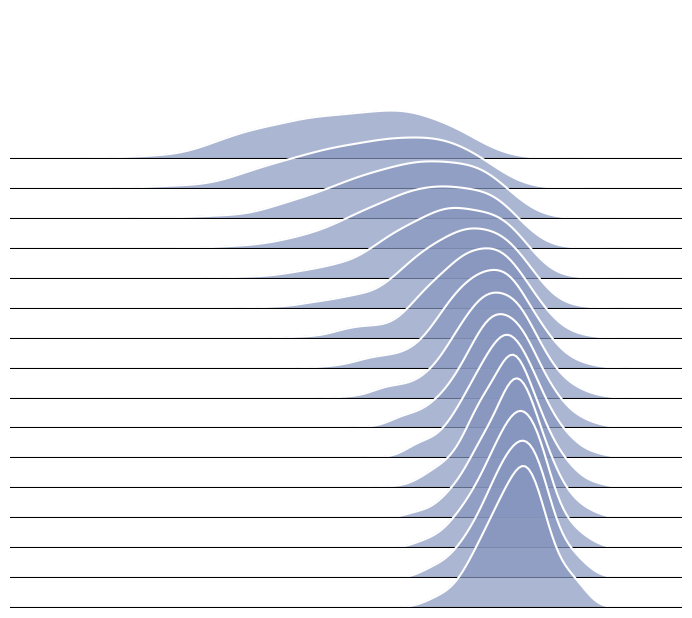

In [303]:
flip_img = np.flip(filtered_maps[1], axis=0)
plot_ridgeplot(matrix=flip_img, matrix_df=labels, Range=(0.7, 2.5), Xlab="", single_color='#455d9cff', single_color_alpha=0.6)

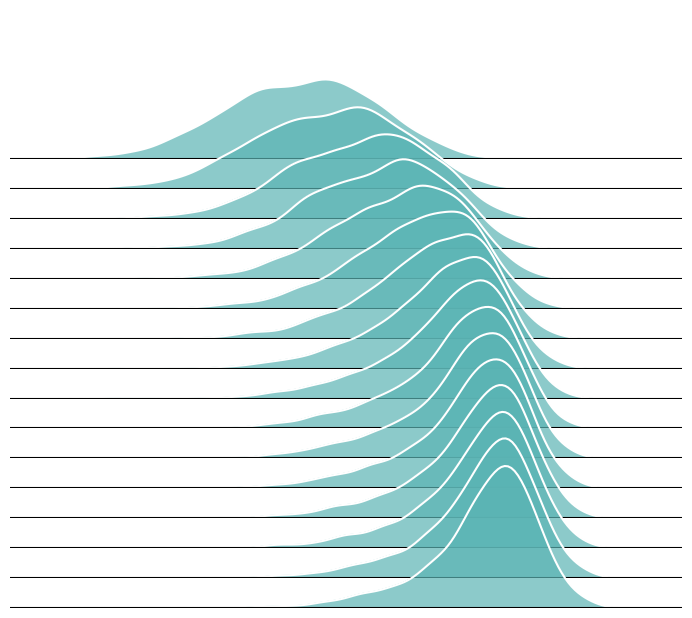

In [302]:
flip_img = np.flip(filtered_maps[2], axis=0)
plot_ridgeplot(matrix=flip_img, matrix_df=labels, Range=(0.7, 2.5), Xlab="", single_color='darkcyan', single_color_alpha=0.6)

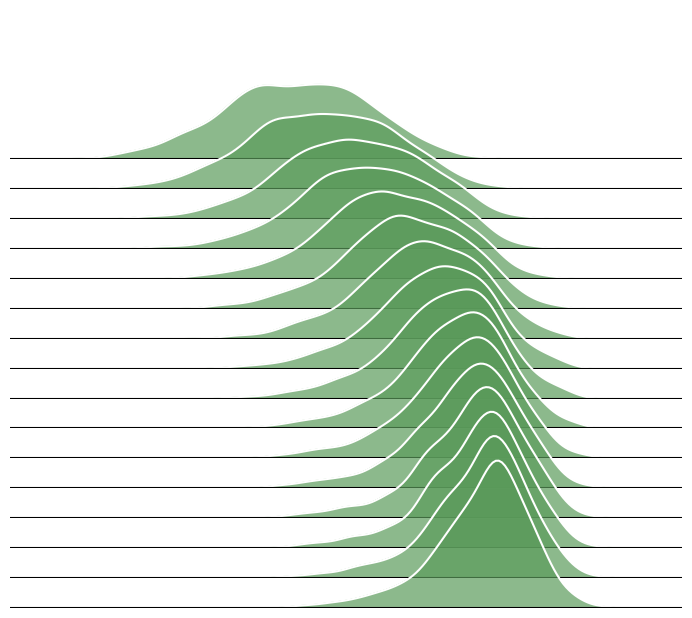

In [301]:
flip_img = np.flip(filtered_maps[3], axis=0)
plot_ridgeplot(matrix=flip_img, matrix_df=labels, Range=(0.7, 2.5), Xlab="", single_color='darkgreen', single_color_alpha=0.6)

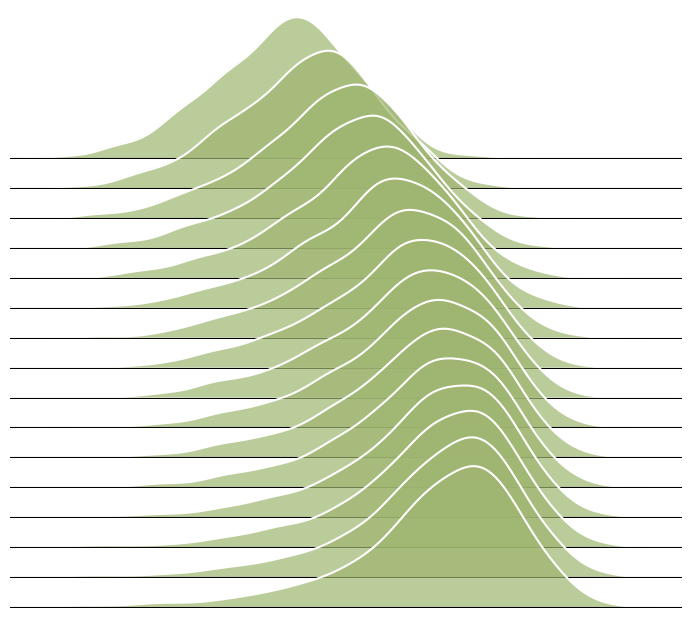

In [300]:
flip_img = np.flip(filtered_maps[4], axis=0)
plot_ridgeplot(matrix=flip_img, matrix_df=labels, Range=(0.7, 2.5), Xlab="", single_color='olivedrab', single_color_alpha=0.6)

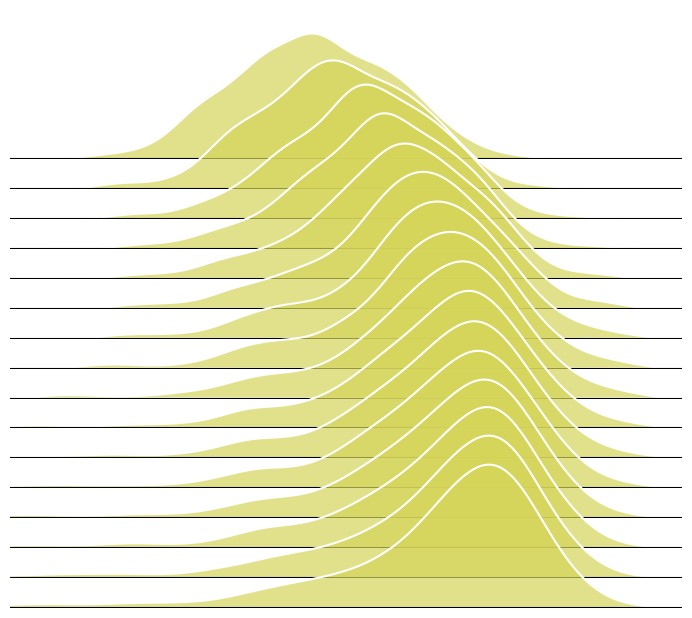

In [299]:
flip_img = np.flip(filtered_maps[5], axis=0)
plot_ridgeplot(matrix=flip_img, matrix_df=labels, Range=(0.7, 2.5), Xlab="", single_color='y', single_color_alpha=0.6)

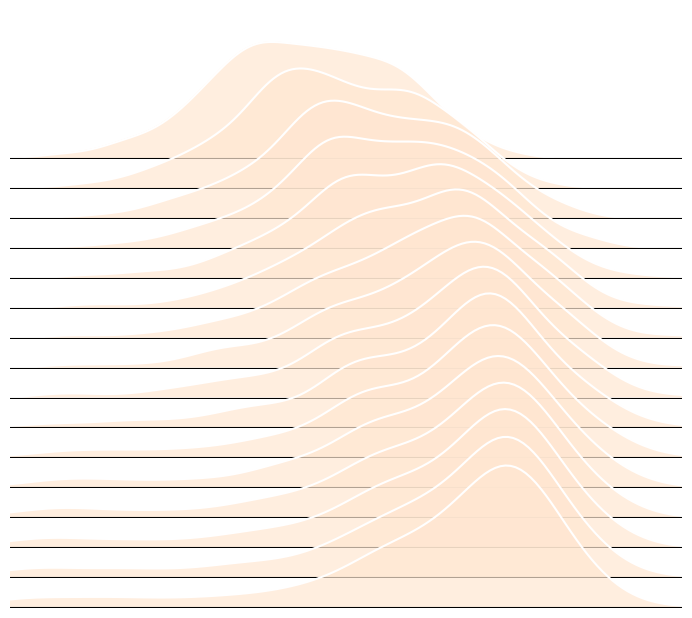

In [298]:
flip_img = np.flip(filtered_maps[6], axis=0)
plot_ridgeplot(matrix=flip_img, matrix_df=labels, Range=(0.7, 2.5), Xlab="", single_color='peachpuff', single_color_alpha=0.6)

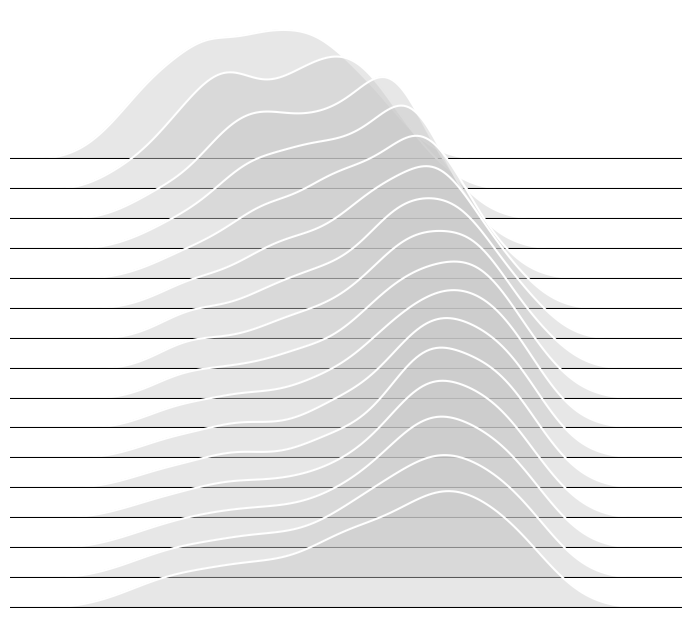

In [297]:
flip_img = np.flip(filtered_maps[7], axis=0)
plot_ridgeplot(matrix=flip_img, matrix_df=labels, Range=(0.7, 2.5), Xlab="", single_color='gray', single_color_alpha=0.25)